# Task 3: Database 1: GSM7744300 - TCells 
Data source: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM7744300
GTF Source: https://www.gencodegenes.org/human/release_38.html

In [73]:
#import necesary functions including windowCNV
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings
from collections.abc import Sequence
import windowCNV as wcnv
import infercnvpy
warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

## Import the data 

In [74]:
import anndata as ad

# Load the text file
df = pd.read_csv("/Users/knm/Library/CloudStorage/OneDrive-JohnsHopkins/Johns Hopkins [2021-2025]/Senior [2024-2025]/CompStemCellBio/Task3/data/withCNV/GSM7744300_GUIDEvsNT_CHR14_RESULTS.txt", sep="\t", index_col=0)  # or ',' if CSV

# Transpose to shape (n_cells, n_features) to match adata format
df_t = df.T

# Create AnnData object
adata = ad.AnnData(X=df_t)
adata.obs_names = df_t.index
adata.var_names = df_t.columns

# Confirm structure
print(adata)


AnnData object with n_obs × n_vars = 33461 × 7172


## Visualize the distrubtion of ground truth CNV

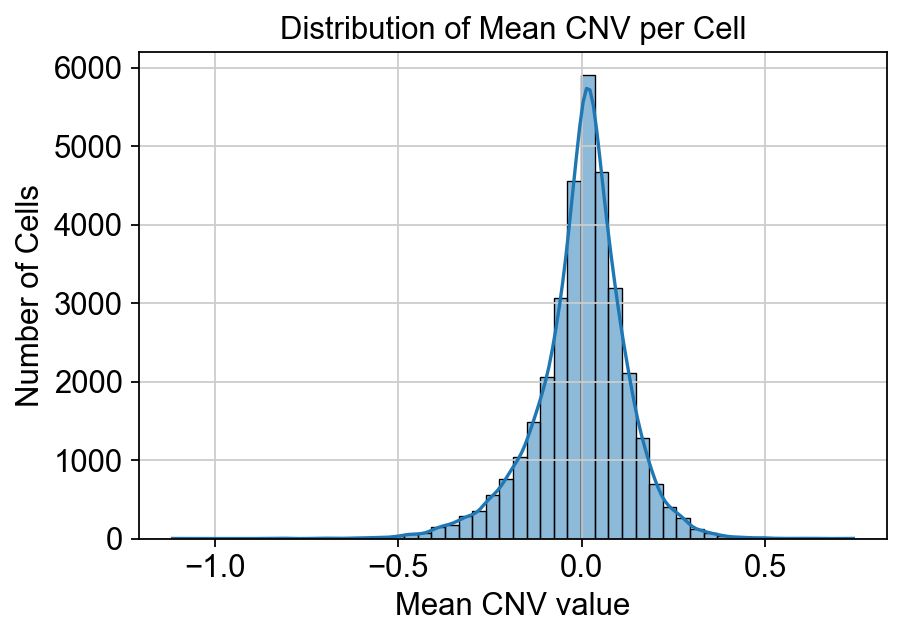

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute summary stats per cell
adata.obs['mean_cnv'] = adata.X.mean(axis=1)

# Plot histogram of mean CNV per cell
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['mean_cnv'], bins=50, kde=True)
plt.title("Distribution of Mean CNV per Cell")
plt.xlabel("Mean CNV value")
plt.ylabel("Number of Cells")
plt.show()


In [ ]:
# Filter out the low count cells 
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_counts=30000)
sc.pp.filter_genes(adata, min_cells=3)


In [75]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata , target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X.copy()

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.25)

In [ ]:
import pandas as pd

# Function to  pars ethe GTF file to be used for downstream analysis
def parse_gtf(gtf_file):
    # Read only gene-level lines
    rows = []
    with open(gtf_file, 'r') as f:
        for line in f:
            if line.startswith("#"):
                continue
            fields = line.strip().split('\t')
            if fields[2] != "gene":
                continue
            chrom, _, _, start, end, _, strand, _, info = fields

            info_dict = {}
            for item in info.strip().split(';'):
                if item.strip():
                    key, value = item.strip().split(' ')
                    info_dict[key] = value.strip('"')

            rows.append({
                "ensembl_id": info_dict.get("gene_id"),
                "gene_name": info_dict.get("gene_name"),
                "chromosome": chrom,
                "start": int(start),
                "end": int(end)
            })

    return pd.DataFrame(rows)

# Load in the GTF data of the human genome
gtf_df = parse_gtf("/Users/knm/Library/CloudStorage/OneDrive-JohnsHopkins/Johns Hopkins [2021-2025]/Senior [2024-2025]/CompStemCellBio/Task3/gencode.v38.annotation.gtf")


## Merge the gene symbol indexes from the loaded GTFs

In [ ]:
# 1. Ensure gene symbols are in a column, not in the index
adata.var['gene_symbol'] = adata.var_names
adata.var.reset_index(drop=True, inplace=True)

# 2. Clean GTF by dropping duplicate gene_name entries
gtf_clean = gtf_df.drop_duplicates(subset='gene_name')

# 3. Merge without expanding rows
adata.var = adata.var.merge(
    gtf_clean[['gene_name', 'chromosome', 'start', 'end']],
    left_on='gene_symbol',
    right_on='gene_name',
    how='left'
)

# 4. Set gene_symbol back as the index and as .var_names
adata.var.set_index('gene_symbol', inplace=True)
adata.var_names = adata.var.index


In [ ]:
print(adata.var.reset_index()[['gene_symbol', 'chromosome', 'start', 'end']].dropna().head())
print(gtf_df['ensembl_id'].unique()[:5])



  gene_symbol chromosome      start        end
0       NOC2L       chr1   944203.0   959309.0
1       ISG15       chr1  1001138.0  1014540.0
2     TNFRSF4       chr1  1211340.0  1214153.0
3        SDF4       chr1  1216909.0  1232067.0
4     B3GALT6       chr1  1232237.0  1235041.0
['ENSG00000223972.5' 'ENSG00000227232.5' 'ENSG00000278267.1'
 'ENSG00000243485.5' 'ENSG00000284332.1']


In [ ]:
# Change formate fo the chromosome variable
adata.var['chromosome'] = adata.var['chromosome'].astype(str)
adata.var['chromosome'] = adata.var['chromosome'].apply(lambda x: f'chr{x}' if not x.startswith('chr') else x)


## Prepare for manual annotation and clustering of the dataset to identify cell types

In [ ]:
import matplotlib.pyplot as plt

# Step 1: PCA and clustering
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3)

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]

# Scale and PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


categories: 0, 1, 2
var_group_labels: CD4+ T cells, Tregs, Proliferating T cells, etc.


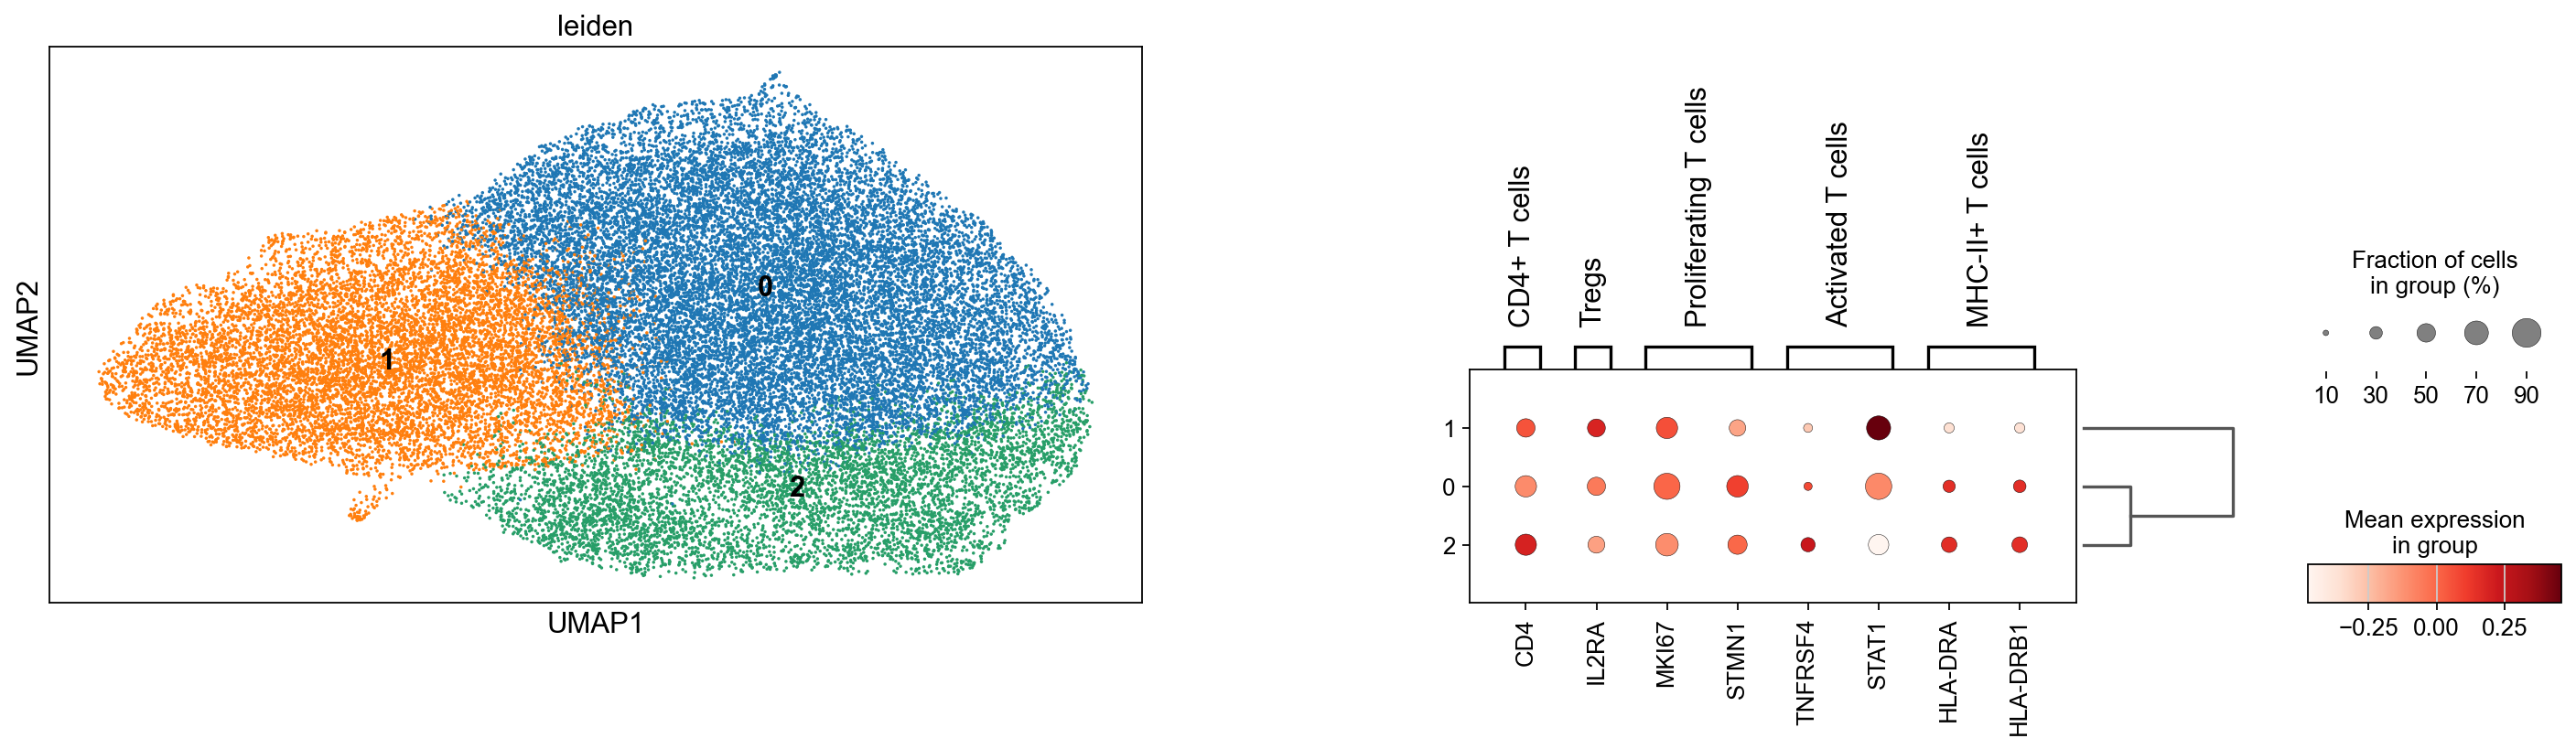

In [ ]:

#  Extract gene symbols from var_names
# Convert var_names to a string Series and extract gene symbols
import pandas as pd

# Create a string Series from var_names
gene_names = pd.Index(adata.var_names).astype(str)

# Step 3: Define marker genes
marker_genes_dict = {
    "CD4+ T cells": ["CD4"],
    "Tregs": ["IL2RA"],
    "Proliferating T cells": ["MKI67", "STMN1"],
    "Activated T cells": ["TNFRSF4", "STAT1"],
    "MHC-II+ T cells": ["HLA-DRA", "HLA-DRB1"]
}

import scanpy as sc

# Compute PCAS and generate clusters
sc.tl.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=5)
sc.tl.leiden(adata, resolution=0.1)
sc.tl.umap(adata)
sc.tl.dendrogram(adata, groupby="leiden")
# Plot Leiden clusters + Dotplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 5), gridspec_kw={'wspace':0.3})
sc.pl.umap(adata, color='leiden', ax=ax1, s=10, legend_loc='on data', show=False)
sc.pl.dotplot(adata, marker_genes_dict, groupby='leiden', gene_symbols='gene_name', ax=ax2, dendrogram=True, show=False)
plt.show()


In [ ]:
# Below are the manually assingeed clustering labels based on the dot plot
cluster_labels = {
    "CD4+ T cells": [2],
    "Tregs": [],
    "Proliferating T cells": [0],
    "Activated T cells": [1],
    "MHC-II+ T cells": []
}

## Add the clustering annoations to the validation set in a new column with the cell types predicted as the names
new_obs_name = 'cell_type'

# Ensure leiden column is of the same type as cluster labels
adata.obs["leiden"] = adata.obs["leiden"].astype(int)

# Initialize with NaN
adata.obs[new_obs_name] = np.nan

# Assign cluster labels
for cell_type, cluster_ids in cluster_labels.items():
    ind = adata.obs["leiden"].isin(cluster_ids)
    adata.obs.loc[ind, new_obs_name] = cell_type

# Convert to categorical type
adata.obs[new_obs_name] = adata.obs[new_obs_name].astype("category")

print(adata.obs[new_obs_name].value_counts())


cell_type
Proliferating T cells    17212
Activated T cells         9957
CD4+ T cells              6292
Name: count, dtype: int64


## Identify reference candidate and then compute WindowCNV calculations

In [ ]:
wcnv.find_reference_candidates(adata)


Top 5 lowest-variance cell types:

Proliferating T cells: avg variance = 0.5419
CD4+ T cells: avg variance = 0.9390
Activated T cells: avg variance = 1.6153


['Proliferating T cells', 'CD4+ T cells', 'Activated T cells']

In [ ]:
wcnv.infercnv(
    adata,
    reference_key='cell_type',
    reference_cat='Proliferating T cells', 
    normalization_mode='reference',
    lfc_clip=3,
    window_distance=5e6,
    min_genes_per_window=5,
    smooth=True,
    dynamic_threshold=1.5,
    exclude_chromosomes=("chrX", "chrY"),
    chunksize=5000,
    n_jobs=4,
    inplace=True,
    layer='counts',
    key_added='cnv',
    calculate_gene_values=False
)


Running inferCNV chunks: 100%|██████████| 7/7 [00:00<00:00, 15.64it/s]


In [ ]:
# Convert sparse matrix to dense
X_cnv = adata.obsm['X_cnv'].toarray()
cnv_df = pd.DataFrame(X_cnv, index=adata.obs_names)
chr_pos = adata.uns['cnv']['chr_pos']
sorted_chr_pos = sorted(chr_pos.items(), key=lambda x: x[1])

window_chromosomes = []
for i, (chrom, start_idx) in enumerate(sorted_chr_pos):
    end_idx = sorted_chr_pos[i + 1][1] if i + 1 < len(sorted_chr_pos) else X_cnv.shape[1]
    window_chromosomes.extend([chrom] * (end_idx - start_idx))

assert len(window_chromosomes) == cnv_df.shape[1]
cnv_df.columns = [f"{chrom}_bin{i}" for i, chrom in enumerate(window_chromosomes)]


## View burden of CNV accross cell types

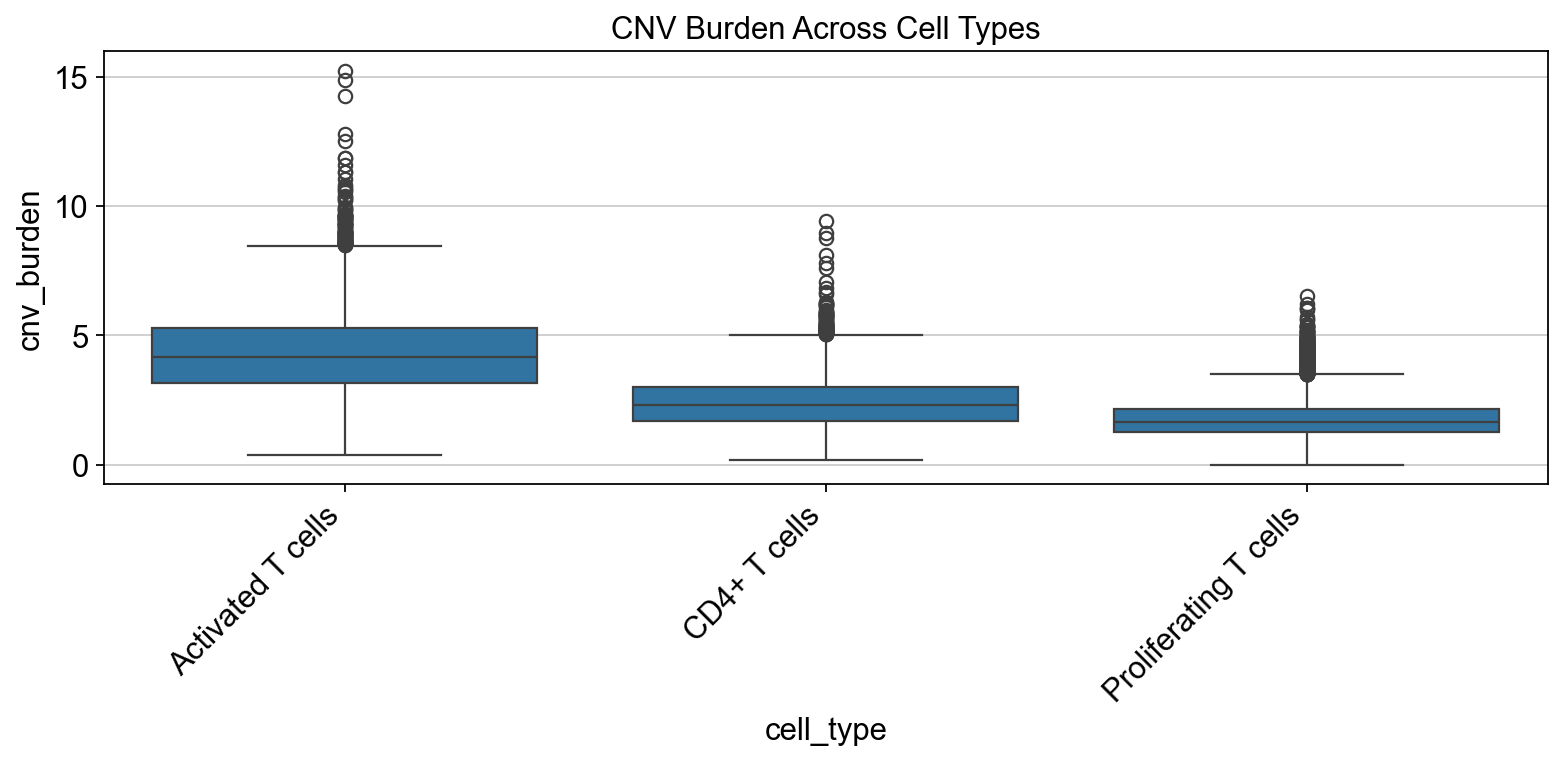

In [ ]:
# Sum of absolute CNV signal per cell
adata.obs["cnv_burden"] = cnv_df.abs().sum(axis=1)

# Boxplot grouped by cell type
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=adata.obs, x="cell_type", y="cnv_burden")
plt.xticks(rotation=45, ha='right')
plt.title("CNV Burden Across Cell Types")
plt.tight_layout()
plt.show()


## Visualize comparitive clustering from the cell type and the CNA clusters

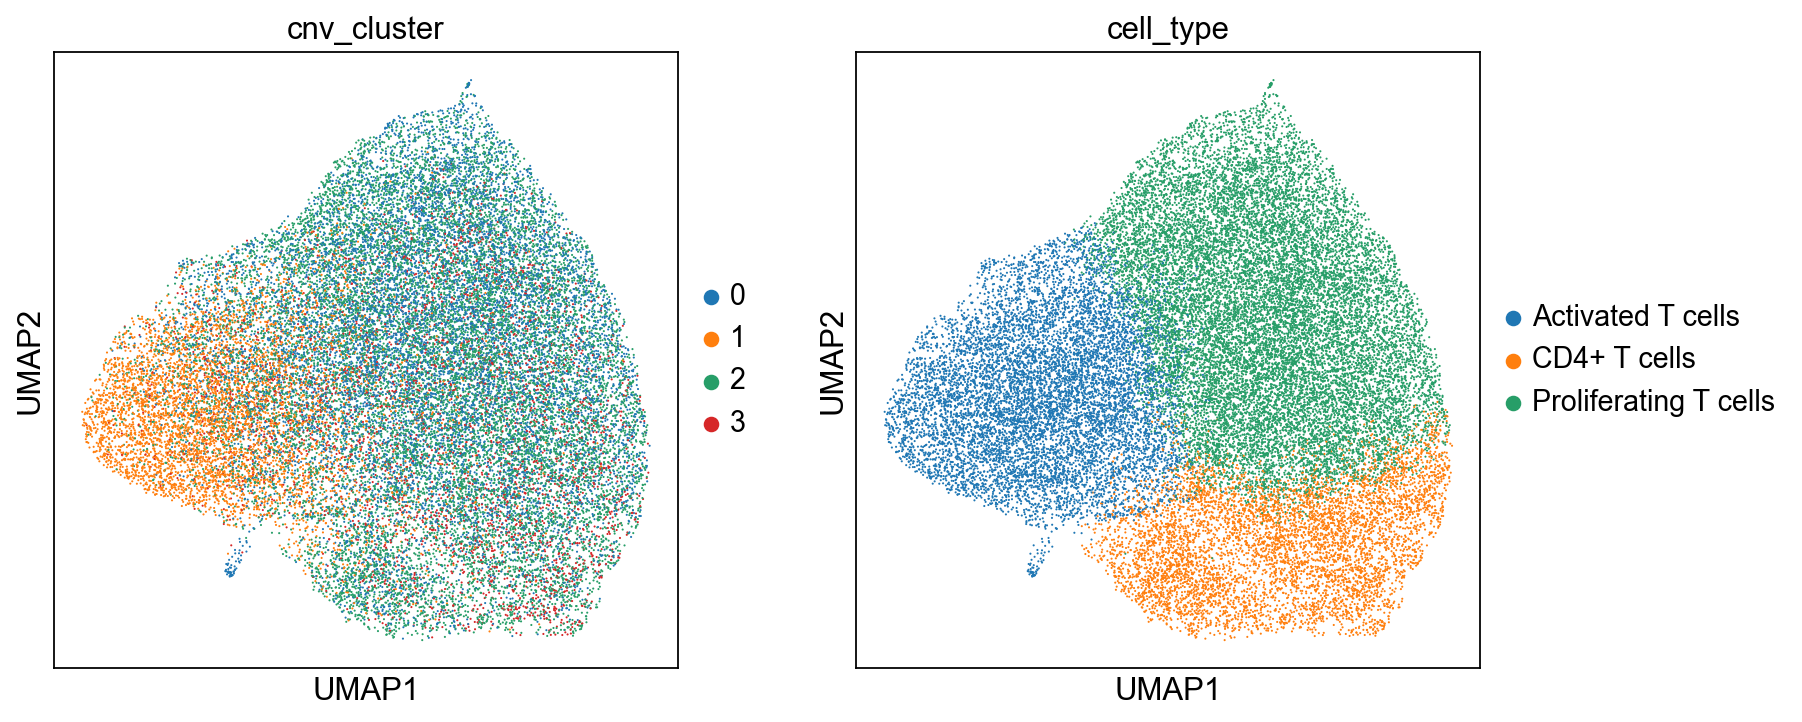

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA for dimensionality reduction
pca = PCA(n_components=10)
cnv_pca = pca.fit_transform(cnv_df)

# Cluster cells using KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
adata.obs["cnv_cluster"] = kmeans.fit_predict(cnv_pca).astype(str)

# Visualize clusters on UMAP
import scanpy as sc
sc.pl.umap(adata, color=["cnv_cluster", "cell_type"])


## Visualize the CNAs for a cell type

[INFO] Gain threshold: > 0.1925
[INFO] Loss threshold: < -0.2033
Assigning CNAs using all cores...


Parallel CNA assignment: 100%|██████████| 33461/33461 [00:04<00:00, 7013.85it/s]


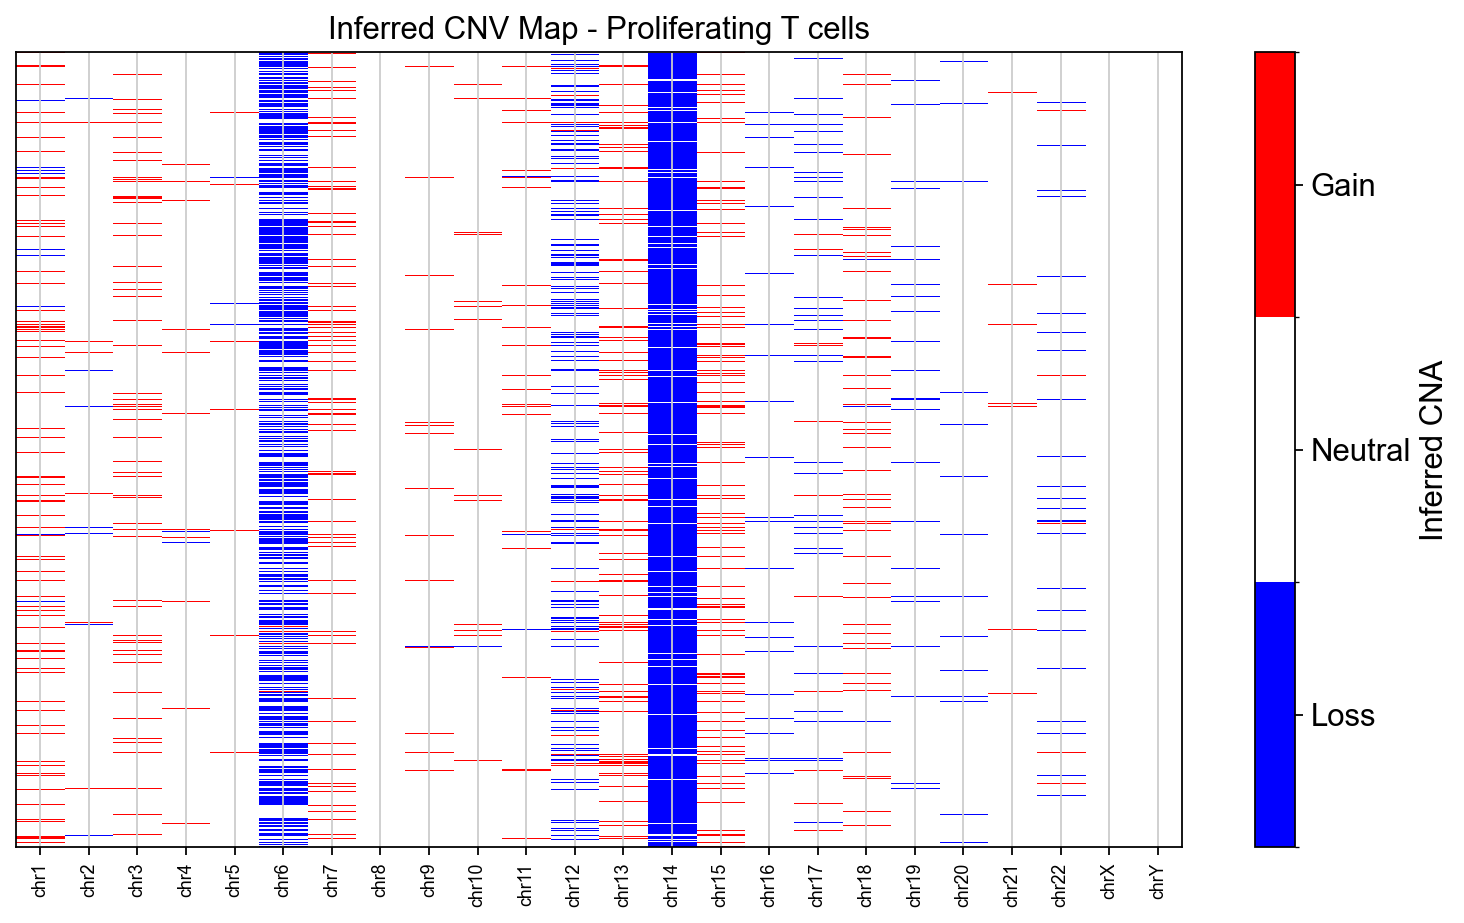

In [ ]:
wcnv.assign_cnas_to_cells_parallel(adata, gain_percentile=60, loss_percentile=60) # Assign CNAs for each cell type for downstream analysis
wcnv.plot_inferred_cnv_map(adata, cell_type="Proliferating T cells") # Plot the CNV Map

## Format the ground truth labels for the CNAs to be used for downstream analysis

In [ ]:
import numpy as np
from tqdm import tqdm

def create_simulated_cnvs_log2(adata, cn_loss_thresh=-1.0, cn_gain_thresh=1.0, key_added="simulated_cnvs", overwrite=True):
    """
    Annotate simulated CNV events based on log2 ratio thresholds from adata.X.
    Stores formatted strings in adata.obs[key_added].
    """
    if not overwrite and key_added in adata.obs and adata.obs[key_added].notna().any():
        print(f"Skipped: '{key_added}' already exists and is non-empty.")
        return

    # Convert matrix if needed
    X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X

    # Fix: Convert chroms_raw from categorical to plain string array
    chroms_raw = adata.var["chromosome"].astype(str).values.astype(str)
    chroms = np.where(np.char.startswith(chroms_raw, "chr"), chroms_raw, np.char.add("chr", chroms_raw))

    starts = adata.var["start"].astype(int).values
    ends = adata.var["end"].astype(int).values

    cnv_strings = []

    for i in tqdm(range(X.shape[0]), desc="Simulating CNVs"):
        row = X[i]
        gains = row >= cn_gain_thresh
        losses = row <= cn_loss_thresh

        entries = []

        for idx in np.where(gains)[0]:
            entries.append(f"{chroms[idx]}:{starts[idx]}-{ends[idx]} (CN 4)")
        for idx in np.where(losses)[0]:
            entries.append(f"{chroms[idx]}:{starts[idx]}-{ends[idx]} (CN 1)")

        cnv_strings.append(", ".join(entries))

    adata.obs[key_added] = cnv_strings



create_simulated_cnvs_log2(adata, cn_loss_thresh=-1.0, cn_gain_thresh=1.0)


Simulating CNVs: 100%|██████████| 33461/33461 [00:07<00:00, 4238.04it/s]


## Evaluate the metrics of the ground truth for the WindowCVN inferred CNVs

[INFO] Gain threshold: > 0.2447
[INFO] Loss threshold: < -0.2186
Excluded GT CNV event due to missing chromosome: ('Activated T cells', 'chr8', 4, 'gain')
Excluded GT CNV event due to missing chromosome: ('CD4+ T cells', 'chr8', 4, 'gain')
Excluded GT CNV event due to missing chromosome: ('Proliferating T cells', 'chr8', 1, 'loss')
Excluded GT CNV event due to missing chromosome: ('Proliferating T cells', 'chr8', 4, 'gain')
Excluded GT CNV event due to missing chromosome: ('CD4+ T cells', 'chr8', 1, 'loss')
Excluded GT CNV event due to missing chromosome: ('Activated T cells', 'chr8', 1, 'loss')


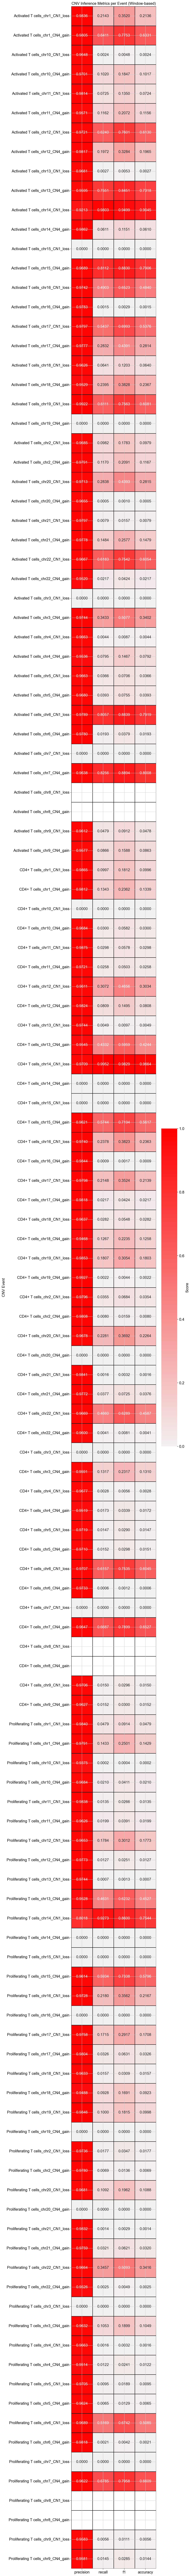

[INFO] Total predicted CNVs: 2846385


(                 cell_type chromosome CN groundtruth        TP      FP  \
 0        Activated T cells       chr1  1        loss   50767.0   849.0   
 1        Activated T cells       chr1  4        gain  176869.0  3512.0   
 2        Activated T cells      chr10  1        loss     137.0     5.0   
 3        Activated T cells      chr10  4        gain    8970.0   276.0   
 4        Activated T cells      chr11  1        loss   12114.0   230.0   
 ..                     ...        ... ..         ...       ...     ...   
 127  Proliferating T cells       chr7  4        gain   24902.0   977.0   
 128  Proliferating T cells       chr8  1        loss       NaN     NaN   
 129  Proliferating T cells       chr8  4        gain       NaN     NaN   
 130  Proliferating T cells       chr9  1        loss     253.0    11.0   
 131  Proliferating T cells       chr9  4        gain    1007.0    44.0   
 
            FN  precision    recall        f1  accuracy  n_events  
 0    186082.0   0.983552  0.2

In [ ]:
wcnv.evaluate_cnv_with_window(adata, gain_percentile=30, loss_percentile=40)

## Generate side by side comparison of the groundtruth and the CNV maps generated by the WindowCNV

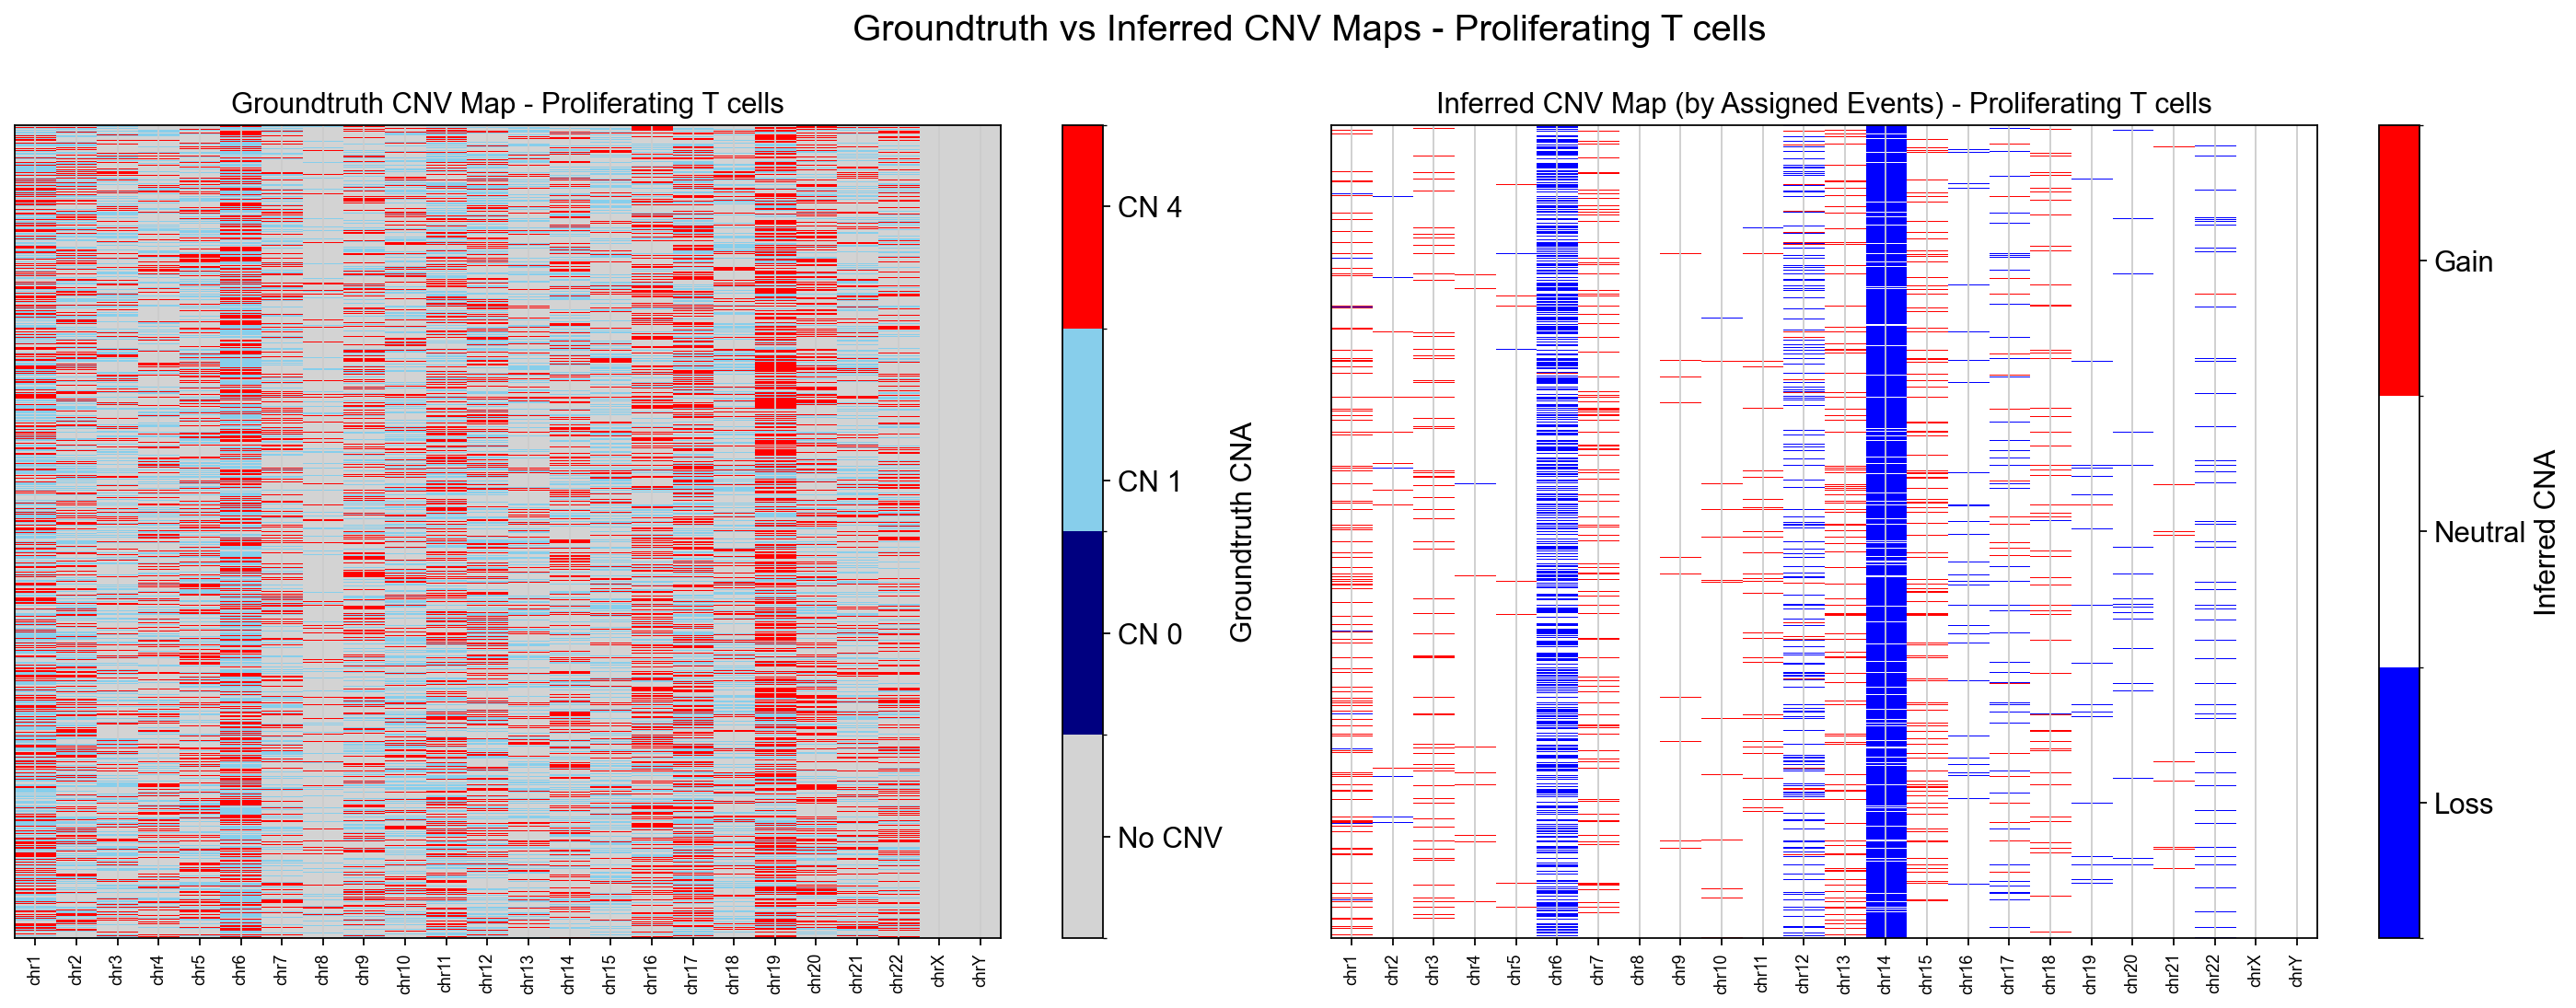

In [ ]:
wcnv.plot_groundtruth_and_inferred_cnv(adata, cell_type="Proliferating T cells")